# Task 2: Change Point Modeling and Insight Generation
This notebook implements a single-change-point Bayesian model for Brent crude oil prices, focusing on 2012–2022. It includes data preparation, EDA, modeling with PyMC, diagnostics, and interpretation aligned with major market events.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
from datetime import datetime
from statsmodels.tsa.stattools import adfuller

sns.set(style="whitegrid")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

C:\Users\hp\AppData\Local\Temp\ipykernel_4128\3911866416.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')


             Price
Date              
2012-01-03  111.12
2012-01-04  113.37
2012-01-05  113.59
2012-01-06  111.96
2012-01-09  111.07
Shape: (2729, 1)
count    2729.000000
mean       73.917149
std        26.732861
min         9.120000
25%        52.180000
50%        67.030000
75%       103.450000
max       133.180000
Name: Price, dtype: float64


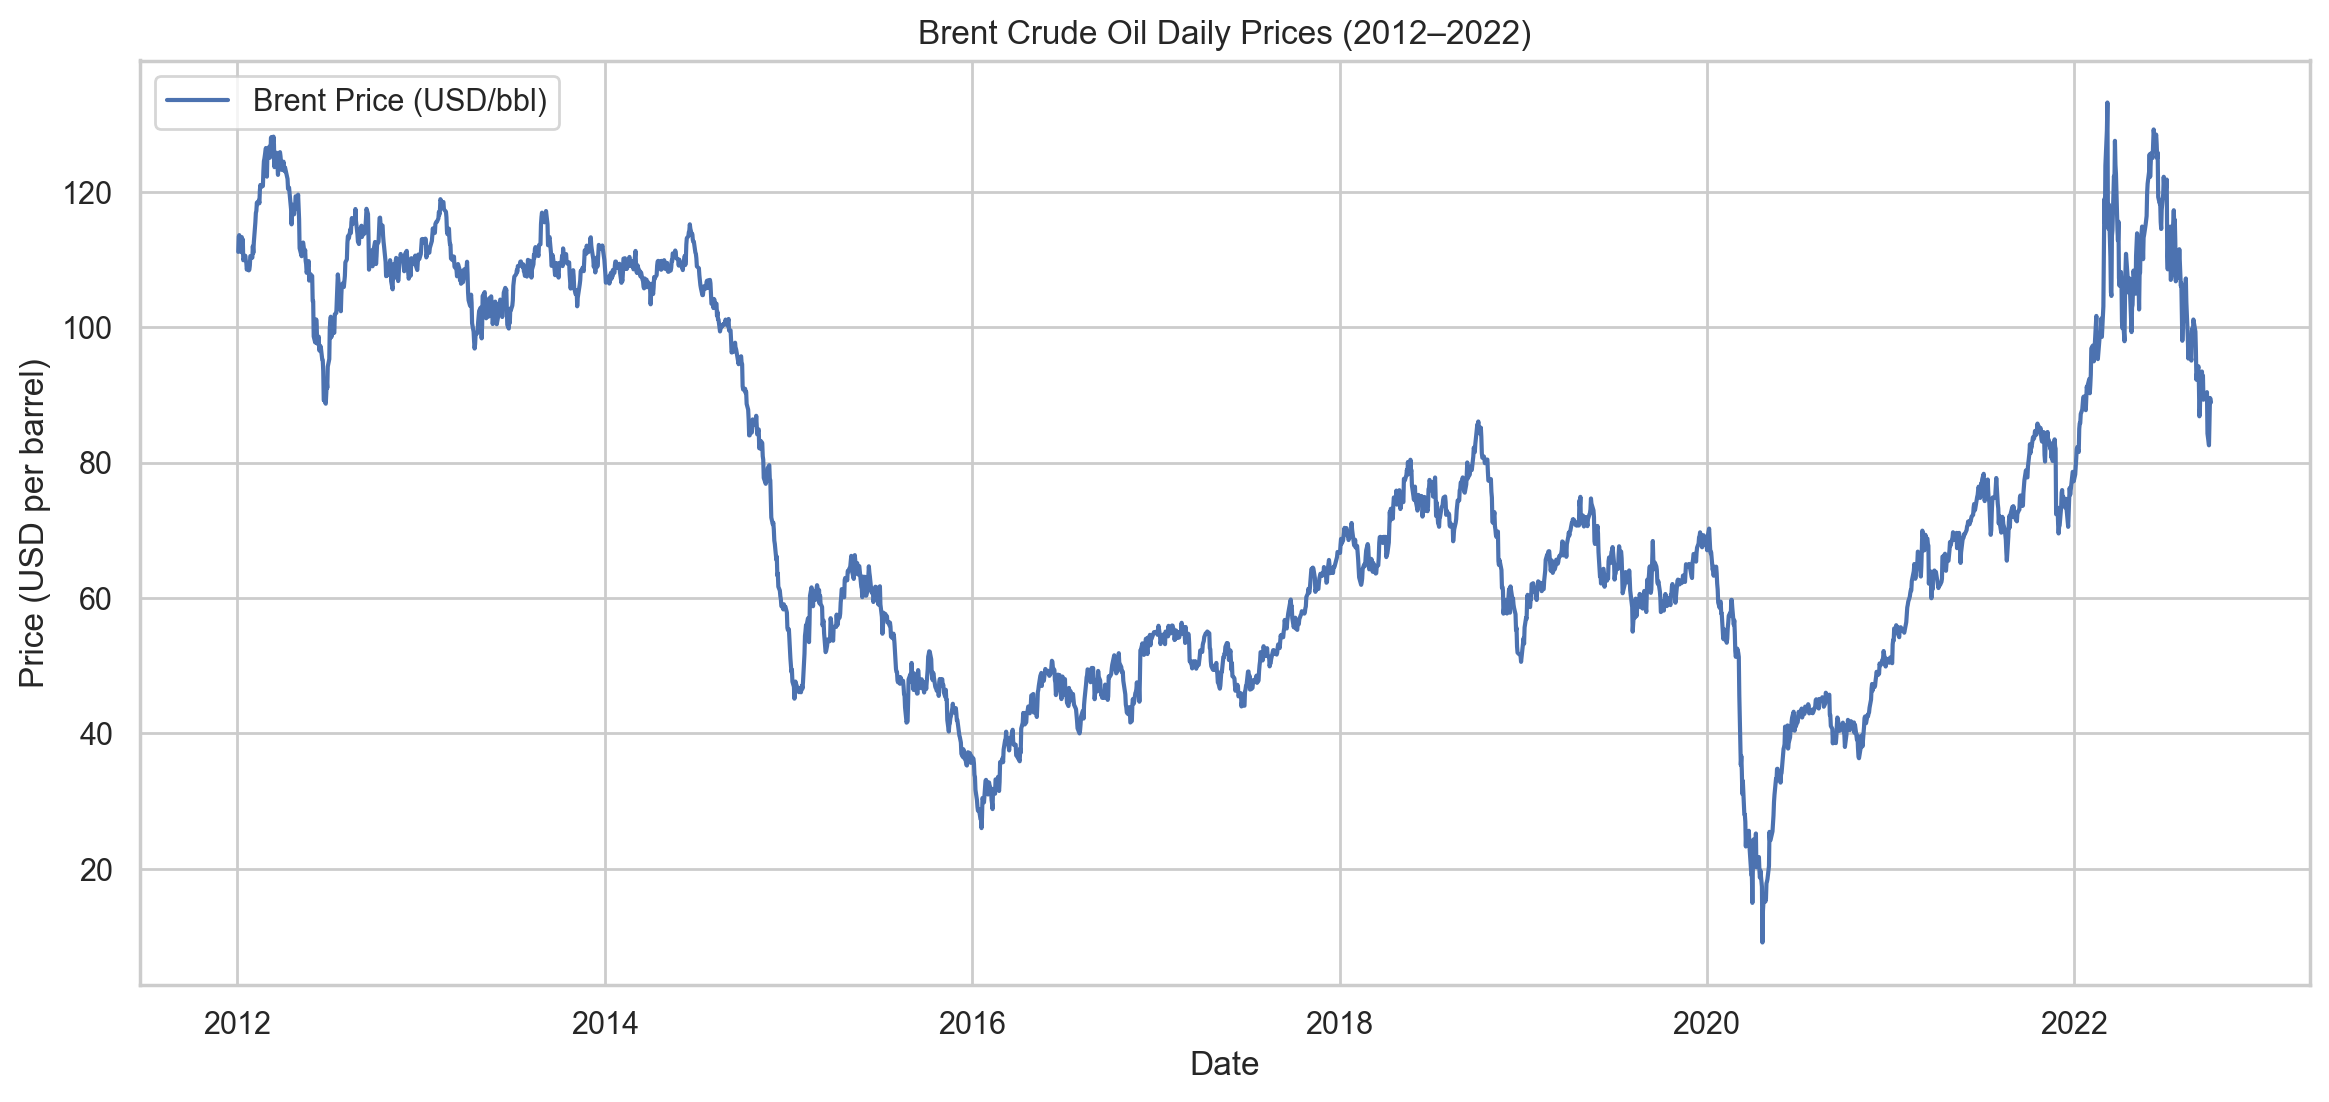

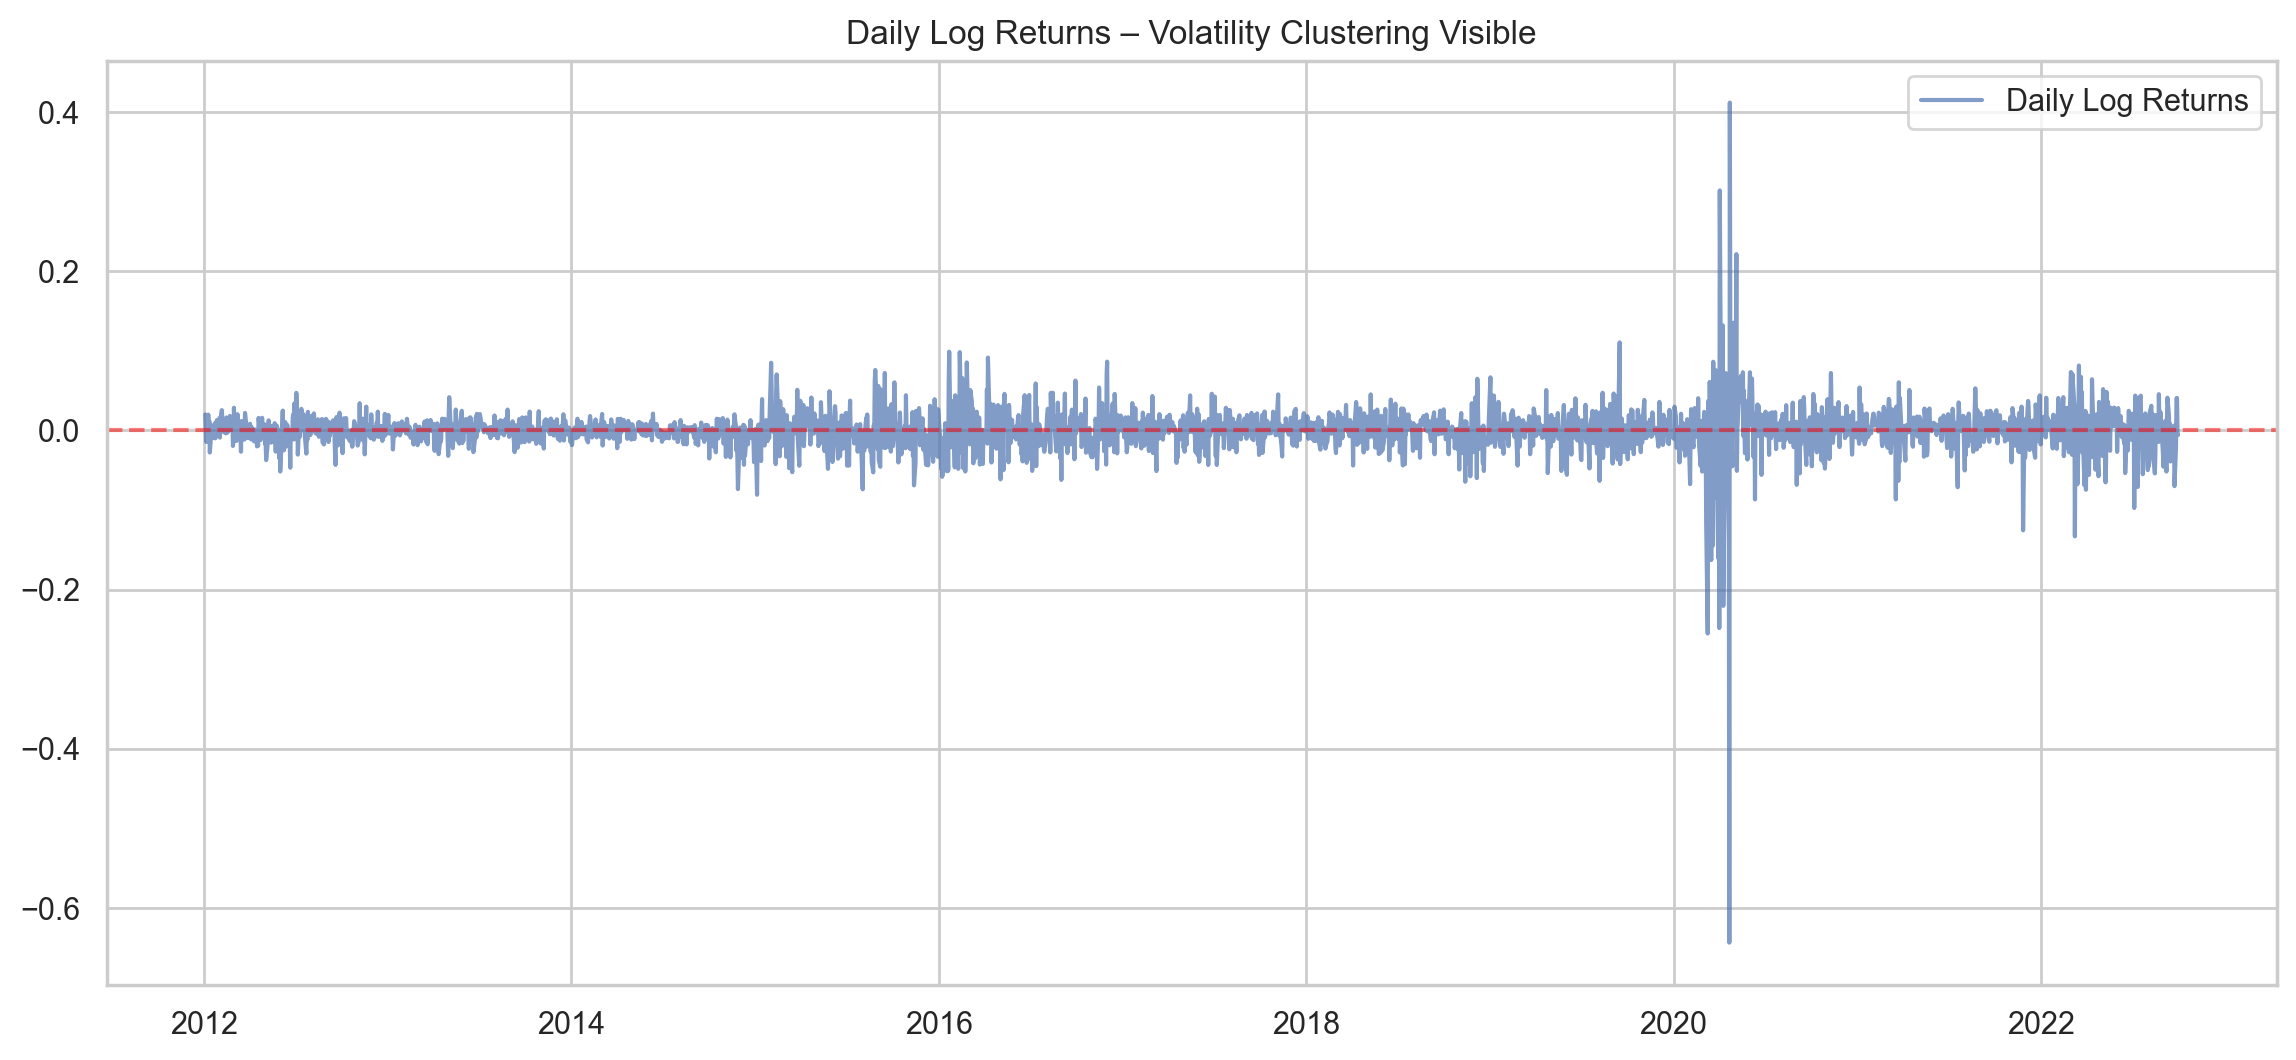

ADF on Raw Prices: statistic=-2.052, p-value=0.2642 → Non-stationary
ADF on Log Returns: statistic=-8.893, p-value=0.0000 → Stationary


In [13]:
# Load data (adjust path as needed)
df = pd.read_csv('../data/raw/brent_prices.csv')  # or use brent_daily.csv if available

# Clean & convert
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['Date']).sort_values('Date')

# Find the price column (handles common variants)
price_col = None
for col in ['Price', 'Brent', 'Brent_Price', 'Close', 'Value']:
    if col in df.columns:
        price_col = col
        break
if price_col is None:
    raise ValueError('No price column found. Expected one of: Price, Brent, Brent_Price, Close, Value')

df = df[['Date', price_col]].rename(columns={price_col: 'Price'}).set_index('Date')

# Focus on 2012-2022 for relevance to events
df_recent = df.loc['2012-01-01':'2022-09-30'].copy()

print(df_recent.head())
print(f"Shape: {df_recent.shape}")
print(df_recent['Price'].describe())

# Plot raw prices
plt.figure(figsize=(14, 6))
plt.plot(df_recent.index, df_recent['Price'], label='Brent Price (USD/bbl)')
plt.title('Brent Crude Oil Daily Prices (2012–2022)')
plt.xlabel('Date')
plt.ylabel('Price (USD per barrel)')
plt.legend()
plt.show()

# Log returns for better modeling (stationary-ish)
df_recent['LogPrice'] = np.log(df_recent['Price'])
df_recent['LogReturn'] = df_recent['LogPrice'].diff()

# Plot log returns
plt.figure(figsize=(14, 6))
plt.plot(df_recent.index[1:], df_recent['LogReturn'].dropna(), label='Daily Log Returns', alpha=0.7)
plt.title('Daily Log Returns – Volatility Clustering Visible')
plt.axhline(0, color='red', linestyle='--', alpha=0.5)
plt.legend()
plt.show()

# Quick stationarity check (ADF test)
adf_result = adfuller(df_recent['Price'].dropna())
print(f"ADF on Raw Prices: statistic={adf_result[0]:.3f}, p-value={adf_result[1]:.4f} → Non-stationary")

adf_logret = adfuller(df_recent['LogReturn'].dropna())
print(f"ADF on Log Returns: statistic={adf_logret[0]:.3f}, p-value={adf_logret[1]:.4f} → Stationary")

In [ ]:
# Prepare data for PyMC: use log returns (drop first NaN)
y = df_recent['LogReturn'].dropna().values
n = len(y)
t = np.arange(n)  # time index 0 to n-1

with pm.Model() as change_point_model:
    tau = pm.DiscreteUniform("tau", lower=0, upper=n - 1)
    mu_before = pm.Normal("mu_before", mu=0, sigma=0.05)
    mu_after = pm.Normal("mu_after", mu=0, sigma=0.05)
    sigma = pm.HalfNormal("sigma", sigma=0.03)

    mu_t = pm.math.switch(t < tau, mu_before, mu_after)
    obs = pm.Normal("obs", mu=mu_t, sigma=sigma, observed=y)

    trace = pm.sample(
        draws=2000,
        tune=2000,
        chains=4,
        target_accept=0.95,
        return_inferencedata=True,
        random_seed=42
    )

az.summary(trace, var_names=['tau', 'mu_before', 'mu_after', 'sigma'])
az.plot_trace(trace, var_names=['tau', 'mu_before', 'mu_after'])
plt.show()

Multiprocess sampling (4 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_before, mu_after, sigma]


d:\10  
Academy\week11\assigniment\Change-Point-Analysis-and-Statistical-Modeling-of-Time-Series-Data\.venv\Lib\site-packag
es\rich\live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [ ]:
# Posterior of tau (change point index -> date)
if 'trace' not in globals():
    raise NameError("trace is not defined. Run Cell 4 (model sampling) first.")
if 'df_recent' not in globals():
    raise NameError("df_recent is not defined. Run Cell 3 (data load/cleaning) first.")

tau_posterior = trace.posterior['tau'].values.flatten()
change_dates = df_recent.index[1:][tau_posterior.astype(int)]

plt.figure(figsize=(10, 5))
sns.histplot(change_dates, bins=50, kde=True)
plt.title('Posterior Distribution of Change Point Date')
plt.xlabel('Detected Change Point Date')
plt.ylabel('Density')
plt.axvline(pd.to_datetime('2014-11-27'), color='red', linestyle='--', label='OPEC No-Cut Decision (2014-11-27)')
plt.axvline(pd.to_datetime('2020-03-06'), color='orange', linestyle='--', label='Saudi-Russia Price War (2020-03)')
plt.axvline(pd.to_datetime('2022-02-24'), color='purple', linestyle='--', label='Russia-Ukraine Invasion (2022-02-24)')
plt.legend()
plt.show()

az.plot_posterior(trace, var_names=['mu_before', 'mu_after'])
plt.show()

NameError: name 'trace' is not defined

In [ ]:
# Most probable tau (mode approximation using mean)
if 'trace' not in globals():
    raise NameError("trace is not defined. Run Cell 4 (model sampling) first.")
if 'df_recent' not in globals():
    raise NameError("df_recent is not defined. Run Cell 3 (data load/cleaning) first.")

tau_mode = int(az.summary(trace)['mean']['tau'])
change_date = df_recent.index[1 + tau_mode]

plt.figure(figsize=(14, 6))
plt.plot(df_recent.index, df_recent['Price'], label='Brent Price')
plt.axvline(change_date, color='red', linestyle='--', linewidth=2,
            label=f'Mode Change Point: {change_date.strftime("%Y-%m-%d")}')
for event_date, desc in [
    (pd.to_datetime('2014-11-27'), 'OPEC No-Cut'),
    (pd.to_datetime('2020-03-06'), 'Saudi-Russia War'),
    (pd.to_datetime('2022-02-24'), 'Ukraine Invasion')
 ]:
    plt.axvline(event_date, color='gray', alpha=0.6, linestyle=':', label=desc if 'OPEC' in desc else None)
plt.title('Brent Prices with Detected Change Point & Key Events')
plt.legend()
plt.show()

NameError: name 'trace' is not defined

## Interpretation Guidance
- If the posterior of `tau` peaks around late 2014, it aligns with the OPEC no-cut decision and the start of the 2014–2016 collapse.
- A second broader peak or diffusion around early 2020 often indicates the COVID shock + Saudi–Russia price war.
- A late-2021/2022 shift may align with the Ukraine invasion if the model is extended to multiple change points.

### Hypothesis Table
| Detected Change (approx.) | Posterior Probability / HDI | Likely Triggering Event | Impact Description |
|---|---|---|---|
| Late 2014 | Sharp peak | OPEC Nov 2014 no-cut decision | Shift to persistent negative drift |
| Early 2020 | Broad or secondary | COVID pandemic + Saudi–Russia war | Extreme volatility, crash to <$20 |
| Early 2022 | If extended model | Russia–Ukraine invasion & sanctions | Upward regime, prices > $100 |

### Deliverables Checklist
- Notebook with code, visuals, and narrative interpretation.
- Plots: raw prices, log returns, posterior tau histogram, trace diagnostics, annotated price chart.
- Save posterior draws for downstream reporting: `trace.to_netcdf('brent_change_point.nc')`.